In [1]:
import anndata
import h5py
import json
import numpy as np
import pandas as pd
import pathlib
import scanpy as sc

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### Load the data

In [2]:
def load_adata(Qced_adata_path):
    
    adata = anndata.read_h5ad(Qced_adata_path)

    # filter the initial QCed cells
    QC_flag = [adata.obs[x] for x in adata.obs.columns if 'flag' in x]
    if len(QC_flag) > 0:
        QC_flag = np.column_stack(QC_flag).all(axis=-1)
        adata = adata[QC_flag]

    if 'Ensemble_ID' in adata.var:
        # reset the var name to Ensemble ID 
        adata.var.set_index('Ensemble_ID', inplace=True)
    if 'real_gene_name' in adata.var:
        adata.var = adata.var.rename(columns={'real_gene_name':'Gene'})

    return adata


In [ ]:
# Qced file path 

chip3_file_path = r'./../../HumanBG_stereo_seq_data/chip3_Y00713F2G4/SAW/Y00713F2G4/outs/feature_expression/Y00713F2G4.adjusted.cellbin_QC_flaged_05142025.h5ad'
chip4_file_path = r'./../../HumanBG_stereo_seq_data/chip4_Y00713C2E3/SAW/Y00713C2E3/outs/feature_expression/Y00713C2E3.adjusted.cellbin_QC_flaged_05082025.h5ad'



In [ ]:
%%time

chip3_adata = load_adata(chip3_file_path)
chip4_adata = load_adata(chip4_file_path)


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/site-packages/pandas/core/frame.py:6191: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  frame.index = index
/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/site-packages/pandas/core/frame.py:6191: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  frame.index = index


CPU times: user 5.56 s, sys: 1.57 s, total: 7.13 s
Wall time: 7.15 s


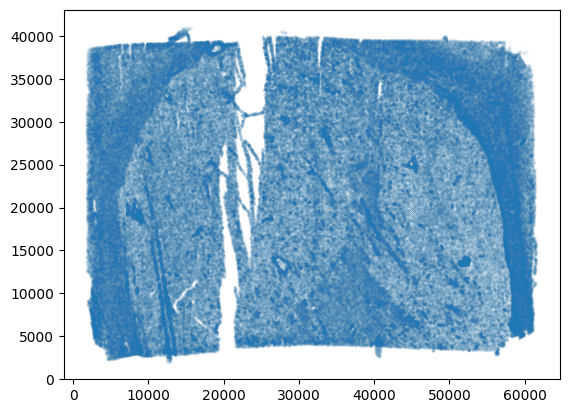

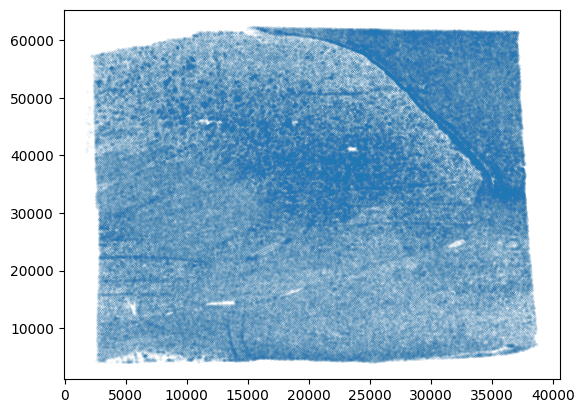

In [5]:
import matplotlib.pyplot as plt


plt.scatter(chip3_adata.obsm['spatial'][:,0],chip3_adata.obsm['spatial'][:,1], s = 0.001)
plt.show()


plt.scatter(chip4_adata.obsm['spatial'][:,0],chip4_adata.obsm['spatial'][:,1], s = 0.001)
plt.show()

# plt.scatter(chip5_adata.obsm['spatial'][:,0],chip5_adata.obsm['spatial'][:,1], s = 0.001)
# plt.show()



#### Concatenate the adata and align Chip3 and Chip4

In [6]:
chip3_x,chip3_y = chip3_adata.obsm['spatial'][:,0].astype(float).copy(),chip3_adata.obsm['spatial'][:,1].astype(float).copy()
chip4_x,chip4_y = chip4_adata.obsm['spatial'][:,0].astype(float).copy(),chip4_adata.obsm['spatial'][:,1].astype(float).copy()

chip3_y = -1*chip3_y 
chip3_y -= chip3_y.min()

chip4_x += (chip3_y.max() - 4500)
cut_off = chip4_x.min()

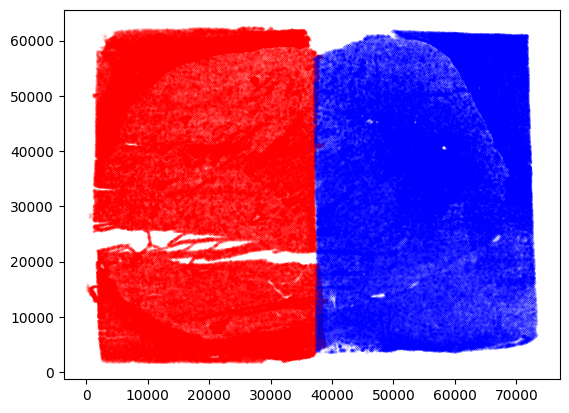

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi = 100)
plt.scatter(chip3_y,chip3_x*1.015 , s = 0.001, c = 'r')
plt.scatter(chip4_x,chip4_y - 500, s = 0.001, c = 'b')
# plt.vlines([cut_off],0, 60000, colors=['black'])
plt.show()

In [8]:
# # make the cell ID unique 

chip3_adata.obs_names =  chip3_adata.obs_names.map(lambda x: 'chip3_' + str(x))
chip4_adata.obs_names =  chip4_adata.obs_names.map(lambda x: 'chip4_' + str(x))
# chip5_adata.obs_names =  chip5_adata.obs_names.map(lambda x: 'chip5_' + str(x))


In [9]:
#### concatenate them and delete to free up space
adata = anndata.concat([chip3_adata,chip4_adata], label='Chip',keys = ['chip3','chip4'],
                       join='outer',
                       merge='same',
                       fill_value=0)
adata

AnnData object with n_obs × n_vars = 1457666 × 68629
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip'
    obsm: 'cell_border', 'spatial'

In [10]:
%%time
temp_var = pd.concat([chip3_adata.var['Gene'],chip4_adata.var['Gene']]).to_frame()
Gene_names = [temp_var.loc[x,'Gene'][0] for x in adata.var_names]
adata.var['Gene'] = Gene_names

<timed exec>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


CPU times: user 1min 26s, sys: 5.26 ms, total: 1min 26s
Wall time: 1min 26s


In [11]:
adata.obs[['x_aligned','y_aligned']] = adata.obs[['x','y']].copy()
adata.obs[['x_aligned','y_aligned']]

,x_aligned,y_aligned
chip3_53760105645974,12517,1942
chip3_53695681136606,12502,2014
chip3_54859617273842,12773,2034
chip3_54778012895207,12754,2023
chip3_54400055773143,12666,2007
...,...,...
chip4_76987288843012,17925,62212
chip4_79109002687243,18419,62219
chip4_78812649943813,18350,62213
chip4_79564269220623,18525,62223


In [12]:
adata = adata.copy()

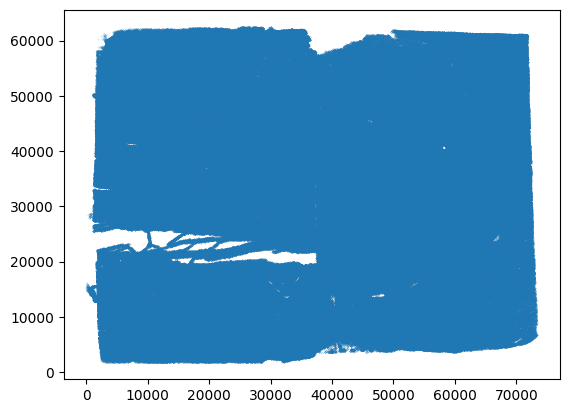

In [13]:
aligned_coord_chip34 = np.hstack([np.array([chip3_y,chip3_x*1.015]),np.array([chip4_x,chip4_y - 500])]).T.astype(np.uint32)
plt.scatter(aligned_coord_chip34[:,0],aligned_coord_chip34[:,1],  s= 0.01)
plt.show()

In [14]:
# update the coordinate for chip 3 - 4
keep = adata.obs['Chip'].isin(['chip3','chip4'])
cellID = adata[keep].obs_names
adata.obs[['x_aligned','y_aligned']] = np.array(adata.obs[['x','y']].values ).copy()
adata.obs.loc[cellID,'x_aligned'] = aligned_coord_chip34[:,0].copy()
adata.obs.loc[cellID,'y_aligned'] = aligned_coord_chip34[:,1].copy()

In [15]:
# replace x with x and y aligned 
adata.obs[['x','y']] = np.array(adata.obs[['x_aligned','y_aligned']]).copy()
adata.obsm['spatial'] = adata.obs[['x','y']].values # update the spatial variable with aligned obs values.

In [16]:
# del chip3_adata
# del chip4_adata

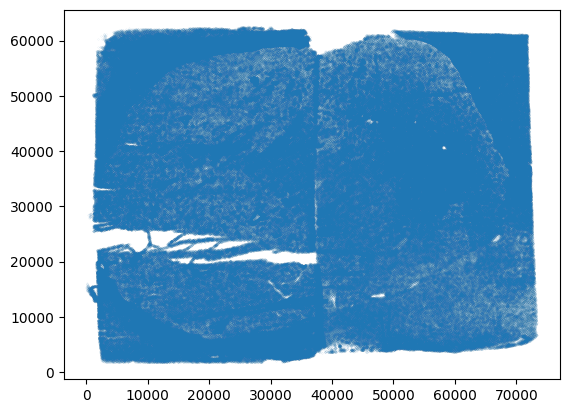

In [16]:
keep = adata.obs['Chip'].isin(['chip3','chip4'])
plt.scatter(adata[keep].obsm['spatial'][:,0],adata[keep].obsm['spatial'][:,1],  s= 0.001)
plt.show()

In [17]:
# keep record of the raw count 
adata.layers['raw_count'] = adata.X.copy()

### Level 1: Graymatter (Striatium), whitematter and ependymal zone.

#### Count Normalization

In [18]:
total_count = np.array(adata.X.sum(axis=-1))
sc.pp.normalize_total(adata, target_sum=np.median(total_count))
sc.pp.log1p(adata)

In [20]:
adata

AnnData object with n_obs × n_vars = 1457666 × 68629
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned'
    var: 'Gene'
    uns: 'log1p'
    obsm: 'cell_border', 'spatial'
    layers: 'raw_count'

#### Compute the spatially weighted gaussian average of the expression matrix

In [21]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm
genes = list(adata.var.index)
adata_weightedAvg = []
for chipID in tqdm.tqdm([['chip3','chip4']], desc = 'weighted average expression'):
    keep = adata.obs['Chip'].isin(chipID)
    X = adata[keep].obsm['spatial']
    d=500
    D = radius_neighbors_graph(
            X, radius=d,          # keep neighbours within d
            mode='distance',      # store the actual distances (use 'connectivity' for 1s)
            include_self=True,   # no self–loops
            metric='euclidean',   # or 'cosine', etc.
            n_jobs=-1             # parallel over all CPU cores
        ).tocsr() 
    W = D.copy()
    w=200
    W.data = np.exp(-0.5*(W.data/w)**2)

    row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
    #row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
    D_inv = sp.diags(1.0 / row_sum)
    W_norm = D_inv @ W
    expr_mat = adata[keep].X  # (n_cells × n_genes)
    expr_neigh = W_norm[::11].dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                             # downsample by 11. This is for testing, later maybe better to use full data
    adataN = sc.AnnData(expr_neigh, var=adata.var)
    adataN.obsm['X_spatial']=adata[keep].obsm['spatial'][::11]
    adataN.obs_names = adata[keep].obs_names[::11] # add the cell ID names
    # keep record of the raw count 
    adataN.layers['raw_count'] = adata[keep].layers['raw_count'][::11]
    adata_weightedAvg.append(adataN)



weighted average expression: 100%|██████████| 1/1 [00:50<00:00, 50.74s/it]


In [22]:
### concatenate and compute the HVGs
adata_weightedAvg = anndata.concat(adata_weightedAvg, label='samples',keys = ['chip3_4'],index_unique='-',
                                   join='outer',
                                   merge='same',
                                   fill_value=0
                                   )

In [23]:
adata_weightedAvg

AnnData object with n_obs × n_vars = 132516 × 68629
    obs: 'samples'
    var: 'Gene'
    obsm: 'X_spatial'
    layers: 'raw_count'

In [24]:
# add the chip information, 
adata_weightedAvg.obs['Chip'] = adata_weightedAvg.obs_names.map(lambda x: x.split('_')[0])
adata_weightedAvg.obs['Chip'] = adata_weightedAvg.obs['Chip'].astype('category')

In [25]:
adata_weightedAvg

AnnData object with n_obs × n_vars = 132516 × 68629
    obs: 'samples', 'Chip'
    var: 'Gene'
    obsm: 'X_spatial'
    layers: 'raw_count'

#### Compute highly variable genes 

In [26]:
%%time
# HVG
sc.pp.highly_variable_genes(
    adata_weightedAvg,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=5000,    # common default
    subset=True,         # keep only HVGs moving forward
    batch_key = 'Chip'
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


CPU times: user 54.4 s, sys: 3.65 s, total: 58 s
Wall time: 13.2 s


In [27]:
adata_weightedAvg

AnnData object with n_obs × n_vars = 132516 × 5000
    obs: 'samples', 'Chip'
    var: 'Gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_spatial'
    layers: 'raw_count'

### Perform the clustering

In [28]:
%%time
sc.pp.scale(adata_weightedAvg, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adata_weightedAvg, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 28min 8s, sys: 6.02 s, total: 28min 14s
Wall time: 29.3 s


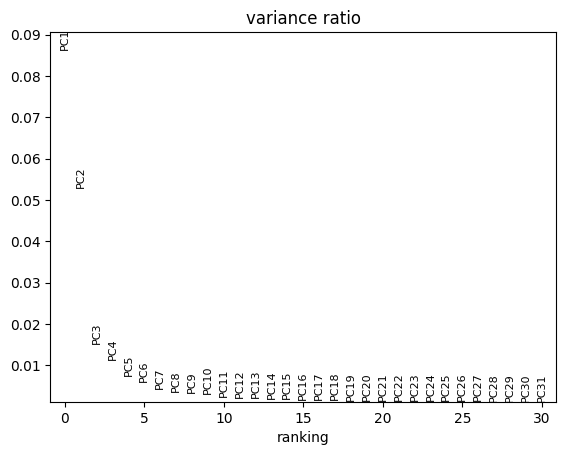

In [29]:
sc.pl.pca_variance_ratio(adata_weightedAvg)

In [30]:
%%time
#### Harmoney integration 
sc.external.pp.harmony_integrate(adata_weightedAvg,'Chip', basis = 'X_pca',)

2025-07-17 10:15:23,554 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-17 10:15:27,068 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-17 10:15:27,381 - harmonypy - INFO - Iteration 1 of 10
2025-07-17 10:15:47,310 - harmonypy - INFO - Iteration 2 of 10
2025-07-17 10:16:07,070 - harmonypy - INFO - Iteration 3 of 10
2025-07-17 10:16:26,868 - harmonypy - INFO - Iteration 4 of 10
2025-07-17 10:16:46,609 - harmonypy - INFO - Converged after 4 iterations


CPU times: user 29min 6s, sys: 12.1 s, total: 29min 18s
Wall time: 1min 23s


In [31]:
adata_weightedAvg

AnnData object with n_obs × n_vars = 132516 × 5000
    obs: 'samples', 'Chip'
    var: 'Gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'pca'
    obsm: 'X_spatial', 'X_pca', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw_count'

In [32]:
%time
sc.pp.neighbors(adata_weightedAvg, n_neighbors=15, n_pcs = 15, use_rep = 'X_pca_harmony')  # uses PCA space by default
sc.tl.umap(adata_weightedAvg, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adata_weightedAvg, resolution=0.05)  

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 8.82 μs


/tmp/ipykernel_1324317/255426936.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_weightedAvg, resolution=0.05)


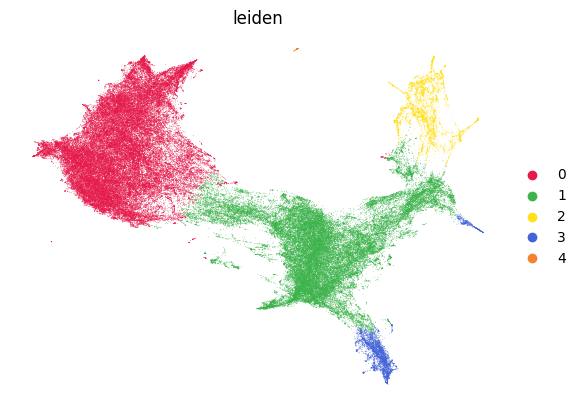

In [33]:
# 7 . Plot UMAP coloured by Leiden clusters
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
sc.pl.umap(adata_weightedAvg,
           color="leiden",        # what to colour by
           frameon=False,         # remove axes frame
        #    legend_loc="on data",
           palette=cmap)  # put cluster labels on the points


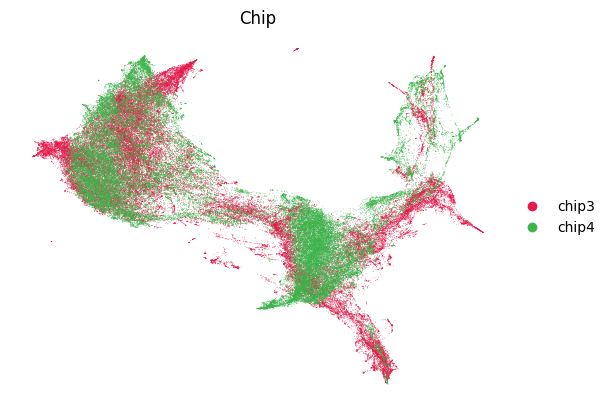

In [34]:
sc.pl.umap(adata_weightedAvg,
           color="Chip",        # what to colour by
           frameon=False,         # remove axes frame
        #    legend_loc="on data",
           palette=cmap)

In [35]:
adata_weightedAvg.obs['samples'].cat.categories

Index(['chip3_4'], dtype='object')

In [36]:
leiden = adata_weightedAvg.obs['leiden']
np.unique(leiden)

array(['0', '1', '2', '3', '4'], dtype=object)

In [37]:
color_map = {ld:clr for ld,clr in zip(adata_weightedAvg.obs['leiden'].cat.categories, adata_weightedAvg.uns['leiden_colors'])}
color_map

{'0': '#e6194b',
 '1': '#3cb44b',
 '2': '#ffe119',
 '3': '#4363d8',
 '4': '#f58231'}

In [38]:
adata_weightedAvg

AnnData object with n_obs × n_vars = 132516 × 5000
    obs: 'samples', 'Chip', 'leiden'
    var: 'Gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Chip_colors'
    obsm: 'X_spatial', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [39]:
np.sort(np.unique(adata_weightedAvg.obs['leiden']).astype(int))

array([0, 1, 2, 3, 4])

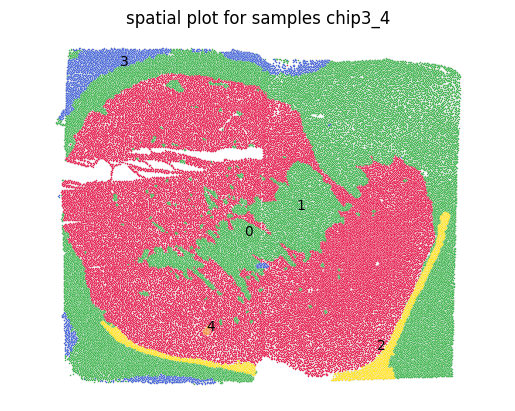

In [46]:
import matplotlib.pylab as plt
import seaborn as sns
# for ld in adata_weightedAvg.obs['leiden'].cat.categories:
for chip in adata_weightedAvg.obs['samples'].cat.categories:
    keep = adata_weightedAvg.obs['samples'].isin([chip])
    XN = np.array(adata_weightedAvg[keep].obsm['X_spatial'])
    leiden = adata_weightedAvg[keep].obs['leiden']
    
    fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
    sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
    for ld in np.unique(leiden):
        sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
        plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
        
    plt.title(f'spatial plot for samples {chip}', fontdict={'color':'k'})
    plt.axis('equal')
    plt.axis('off')
    plt.show()

#### Annotation

In [47]:
# annotation 
ledien_annotation = {0:'Gray_matter',
                     1:'White_matter',
                     2:'ependymal_zone',
                     3:'White_matter',
                     4:'artifact',
                }
ledien_annotation = {str(k):v for k,v in ledien_annotation.items()}


In [48]:
adata_weightedAvg.obs['Highlevel_spatialmodule'] = adata_weightedAvg.obs['leiden'].replace(ledien_annotation) 
adata_weightedAvg.obs['Highlevel_spatialmodule'] 

/tmp/ipykernel_1324317/1554143684.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_weightedAvg.obs['Highlevel_spatialmodule'] = adata_weightedAvg.obs['leiden'].replace(ledien_annotation)


chip3_53760105645974-chip3_4       Gray_matter
chip3_19623705577722-chip3_4      White_matter
chip3_23102629087483-chip3_4      White_matter
chip3_53077205846112-chip3_4       Gray_matter
chip3_54236847015943-chip3_4       Gray_matter
                                     ...      
chip4_70901320184646-chip3_4    ependymal_zone
chip4_71940702270250-chip3_4    ependymal_zone
chip4_74229919839016-chip3_4    ependymal_zone
chip4_76643691459335-chip3_4    ependymal_zone
chip4_79379585626891-chip3_4    ependymal_zone
Name: Highlevel_spatialmodule, Length: 132516, dtype: category
Categories (4, object): ['Gray_matter', 'White_matter', 'ependymal_zone', 'artifact']

In [49]:
# remove the artifact clusteres 
keep =  adata_weightedAvg.obs['Highlevel_spatialmodule'].isin(['artifact'])
adata_weightedAvg = adata_weightedAvg[~keep].copy()
adata_weightedAvg

AnnData object with n_obs × n_vars = 132349 × 5000
    obs: 'samples', 'Chip', 'leiden', 'Highlevel_spatialmodule'
    var: 'Gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Chip_colors'
    obsm: 'X_spatial', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [50]:
np.unique(adata_weightedAvg.obs['Highlevel_spatialmodule'])

array(['Gray_matter', 'White_matter', 'ependymal_zone'], dtype=object)

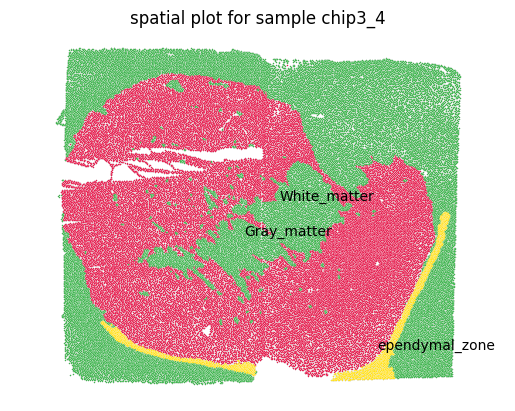

In [51]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata_weightedAvg.obs['Highlevel_spatialmodule'].cat.categories)}
for chip in adata_weightedAvg.obs['samples'].cat.categories:
    keep = adata_weightedAvg.obs['samples'].isin([chip])
    XN = np.array(adata_weightedAvg[keep].obsm['X_spatial'])
    leiden = adata_weightedAvg[keep].obs['Highlevel_spatialmodule']
    
    fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
    sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
    for ld in np.unique(leiden):
        sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
        plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
        
    plt.title(f'spatial plot for sample {chip}', fontdict={'color':'k'})
    plt.axis('equal')
    plt.axis('off')
    plt.show()

In [52]:
adata

AnnData object with n_obs × n_vars = 1457666 × 68629
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned'
    var: 'Gene'
    uns: 'log1p'
    obsm: 'cell_border', 'spatial'
    layers: 'raw_count'

#### Transefer the label to the full dataset

In [53]:
adata.obs['Chip'].unique()

['chip3', 'chip4']
Categories (2, object): ['chip3', 'chip4']

In [54]:
# adata
import scipy
import scipy.spatial
from tqdm import tqdm 
adata.obs['Highlevel_spatialmodule'] = 'unassigned'
for chip_ID in tqdm([['chip3', 'chip4']], desc = 'transfering label to full dataset'):
    
    ref_cellID = adata_weightedAvg[adata_weightedAvg.obs['Chip'].isin(chip_ID)].obs_names
    query_cellID = adata[adata.obs['Chip'].isin(chip_ID)].obs_names

    ref_spatial = adata_weightedAvg[ref_cellID].obsm['X_spatial'].copy()
    query_spatial = adata[query_cellID].obsm['spatial']
    tree = scipy.spatial.KDTree(ref_spatial)
    _,ind = tree.query(query_spatial,k=1)
    labels = adata_weightedAvg.obs.loc[ref_cellID,'Highlevel_spatialmodule'].values
    adata.obs.loc[query_cellID,'Highlevel_spatialmodule'] = labels[ind]

adata.obs['Highlevel_spatialmodule'] = adata.obs['Highlevel_spatialmodule'].astype('category')

transfering label to full dataset: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


- visualize the full data to make sure the label transfer is done correctly 

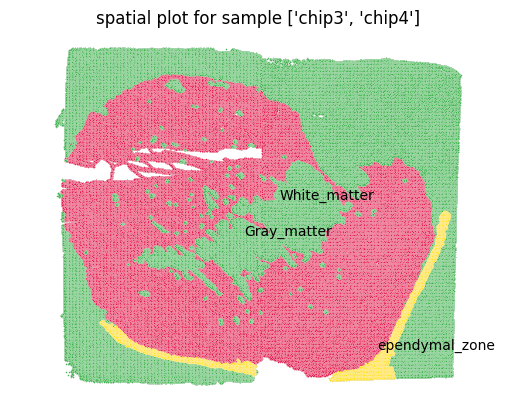

In [55]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['Highlevel_spatialmodule'].cat.categories)}
for chip_ID in [['chip3', 'chip4']]:
    keep = adata.obs['Chip'].isin(chip_ID)
    XN = np.array(adata[keep].obsm['spatial'])
    leiden = adata[keep].obs['Highlevel_spatialmodule']
    
    fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
    sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
    for ld in np.unique(leiden):
        sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
        plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
        
    plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'k'})
    plt.axis('equal')
    plt.axis('off')
    plt.show()

### Level-2: Subclustering of the Gray-matter -> Ca(Cuadate),Pu(Putamen) and NAC(nucleus accumbens)

In [56]:
np.unique(adata.obs['Highlevel_spatialmodule'])

array(['Gray_matter', 'White_matter', 'ependymal_zone'], dtype=object)

#### Subset the data to graymatter and compute the spatially weighted expression matrix

In [57]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm
genes = list(adata.var.index)
adata_weightedAvg = []
for chipID in tqdm.tqdm([['chip3','chip4']], desc = 'weighted average expression'):
    keep = adata.obs['Chip'].isin(chipID)
    GM_cell_idx = np.where(adata[keep].obs['Highlevel_spatialmodule'].isin(['Gray_matter']))[0]
    # for sake of computational ease downsample by 5
    GM_cell_idx = np.random.choice(GM_cell_idx, size = len(GM_cell_idx)//5, replace=False)

    X = adata[keep][GM_cell_idx].obsm['spatial']
    d=1500
    D = radius_neighbors_graph(
            X, radius=d,          # keep neighbours within d
            mode='distance',      # store the actual distances (use 'connectivity' for 1s)
            include_self=True,   # no self–loops
            metric='euclidean',   # or 'cosine', etc.
            n_jobs=-1             # parallel over all CPU cores
        ).tocsr() 
    W = D.copy()
    w=500 # this will determine the decay rate of the gaussian 
    W.data = np.exp(-0.5*(W.data/w)**2)

    row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
    #row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
    D_inv = sp.diags(1.0 / row_sum)
    W_norm = D_inv @ W
    expr_mat = adata[keep][GM_cell_idx].X  # (n_cells × n_genes)
    expr_neigh = W_norm.dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                             # downsample by 11. This is for testing, later maybe better to use full data
    adataN = sc.AnnData(expr_neigh, var=adata.var)
    adataN.obsm['X_spatial']=adata[keep][GM_cell_idx].obsm['spatial']
    adataN.obs_names = adata[keep][GM_cell_idx].obs_names # add the cell ID names
    # keep record of the raw count 
    adataN.layers['raw_count'] = adata[keep][GM_cell_idx].layers['raw_count']
    adata_weightedAvg.append(adataN)



weighted average expression: 100%|██████████| 1/1 [01:09<00:00, 69.15s/it]


In [58]:
### concatenate and compute the HVGs
adata_weightedAvg = anndata.concat(adata_weightedAvg, label='samples',keys = ['chip3_4'],index_unique='-',
                                   join='outer',
                                   merge='same',
                                   fill_value=0
                                   )

# add the chip information, 
adata_weightedAvg.obs['Chip'] = adata_weightedAvg.obs_names.map(lambda x: x.split('_')[0])
adata_weightedAvg.obs['Chip'] = adata_weightedAvg.obs['Chip'].astype('category')


In [59]:
adata_weightedAvg.obs['samples']

chip4_123802432330718-chip3_4    chip3_4
chip4_19834159023834-chip3_4     chip3_4
chip4_82124069726114-chip3_4     chip3_4
chip3_43757126826298-chip3_4     chip3_4
chip3_233070695297430-chip3_4    chip3_4
                                  ...   
chip3_95876554955481-chip3_4     chip3_4
chip3_195545566030298-chip3_4    chip3_4
chip4_33071248237349-chip3_4     chip3_4
chip3_74311524169170-chip3_4     chip3_4
chip4_37426345074020-chip3_4     chip3_4
Name: samples, Length: 150921, dtype: category
Categories (1, object): ['chip3_4']

In [60]:
adata_weightedAvg

AnnData object with n_obs × n_vars = 150921 × 68629
    obs: 'samples', 'Chip'
    var: 'Gene'
    obsm: 'X_spatial'
    layers: 'raw_count'

#### Get highly variable genes

In [61]:
# HVG
sc.pp.highly_variable_genes(
    adata_weightedAvg,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=5000,    # common default
    subset=True,         # keep only HVGs moving forward
    batch_key = 'Chip'
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


#### Perform Clustering 

In [63]:
%%time
sc.pp.scale(adata_weightedAvg, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adata_weightedAvg, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 34min 8s, sys: 6.52 s, total: 34min 14s
Wall time: 35.7 s


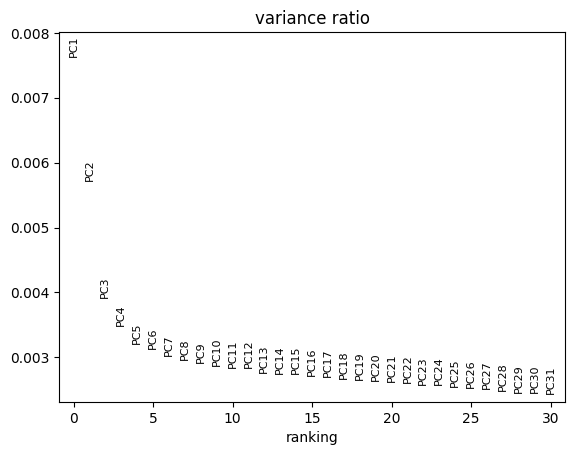

In [64]:
sc.pl.pca_variance_ratio(adata_weightedAvg)

In [65]:
# do harmoney integration
sc.external.pp.harmony_integrate(adata_weightedAvg,'Chip', basis = 'X_pca',)

2025-07-17 10:23:47,303 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-17 10:23:50,852 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-17 10:23:51,203 - harmonypy - INFO - Iteration 1 of 10
2025-07-17 10:24:14,600 - harmonypy - INFO - Iteration 2 of 10
2025-07-17 10:24:37,847 - harmonypy - INFO - Converged after 2 iterations


In [88]:
%time
# clustering 
sc.pp.neighbors(adata_weightedAvg, n_neighbors=10, n_pcs = 15, use_rep = 'X_pca_harmony')  # uses PCA space by default
sc.tl.umap(adata_weightedAvg, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adata_weightedAvg, resolution=0.002)  

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 9.54 μs


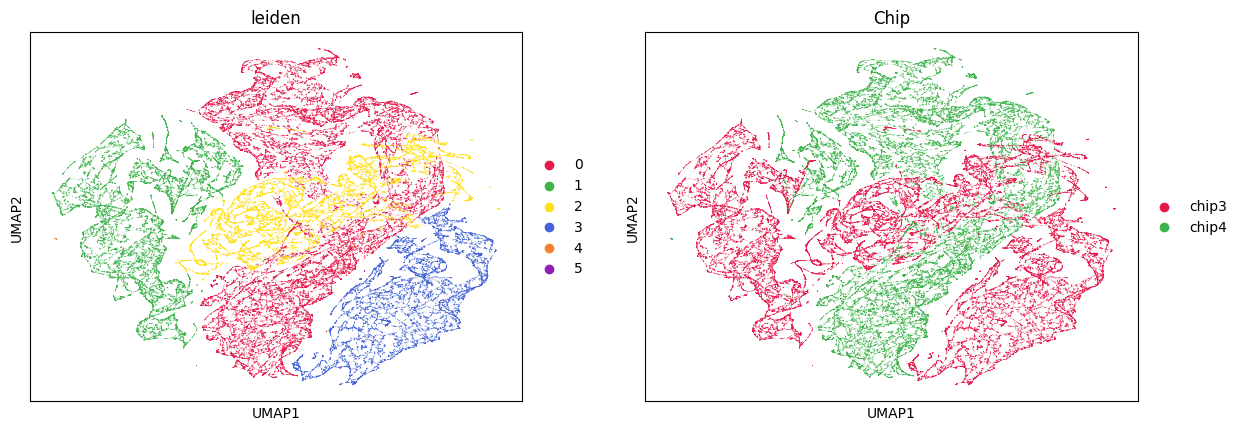

In [89]:
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#030303", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

sc.pl.umap(
    adata_weightedAvg,
    color = ['leiden','Chip'],
    palette = cmap
)

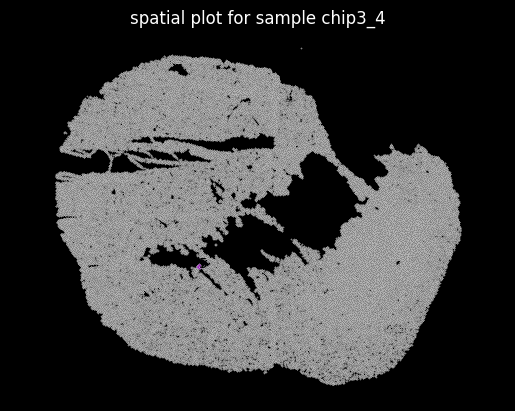

In [97]:
import matplotlib.pylab as plt
import seaborn as sns
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata_weightedAvg.obs['leiden'].cat.categories)}
for chip in adata_weightedAvg.obs['samples'].cat.categories:
    keep = adata_weightedAvg.obs['samples'].isin([chip])
    XN = np.array(adata_weightedAvg[keep].obsm['X_spatial'])
    leiden = adata_weightedAvg[keep].obs['leiden']
    
    fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
    sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
    for ld in ['5']:#np.unique(leiden):
        sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
        plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
        
    plt.title(f'spatial plot for sample {chip}', fontdict={'color':'w'})
    plt.axis('equal')
    plt.axis('off')
    plt.show()

In [91]:
np.unique(adata_weightedAvg.obs['leiden'])

array(['0', '1', '2', '3', '4', '5'], dtype=object)

#### Annotaiton

In [99]:
region_mapper = {0:'Caudate',
                 1:'Putamen',
                 2:'Putamen',
                 3:'NAC_shell',
                 4:'artifact',
                 5:'artifact'
                 } 
region_mapper = {str(k):v for k,v in region_mapper.items()}
adata_weightedAvg.obs['spatialmodule_GrayMatter_subclustered'] = adata_weightedAvg.obs['leiden'].replace(region_mapper)


/tmp/ipykernel_1324317/3297954237.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_weightedAvg.obs['spatialmodule_GrayMatter_subclustered'] = adata_weightedAvg.obs['leiden'].replace(region_mapper)


In [100]:
np.unique(adata_weightedAvg.obs['spatialmodule_GrayMatter_subclustered'])

array(['Caudate', 'NAC_shell', 'Putamen', 'artifact'], dtype=object)

In [102]:
# remove the artifact clusteres 
keep = ~adata_weightedAvg.obs['spatialmodule_GrayMatter_subclustered'].isin(['artifact'])
adata_weightedAvg = adata_weightedAvg[keep].copy()
adata_weightedAvg

AnnData object with n_obs × n_vars = 150810 × 5000
    obs: 'samples', 'Chip', 'leiden', 'spatialmodule_GrayMatter_subclustered'
    var: 'Gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Chip_colors'
    obsm: 'X_spatial', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

#### Transfer the label to the full data 

In [110]:
adata.obs['spatialmodule_GrayMatter_subclustered'] =  adata.obs['Highlevel_spatialmodule'].copy()
adata.obs['spatialmodule_GrayMatter_subclustered'] = adata.obs['spatialmodule_GrayMatter_subclustered'].astype('str')
cellID = adata[adata.obs['spatialmodule_GrayMatter_subclustered'].isin(['Gray_matter'])].obs_names

tree = scipy.spatial.KDTree(adata_weightedAvg.obsm['X_spatial'])
_,ind = tree.query(adata[cellID].obsm['spatial'], k = 1)

adata.obs.loc[cellID,'spatialmodule_GrayMatter_subclustered'] = adata_weightedAvg.obs['spatialmodule_GrayMatter_subclustered'].values[ind]

adata.obs['spatialmodule_GrayMatter_subclustered'] = adata.obs['spatialmodule_GrayMatter_subclustered'].astype('category') 

- plot the data to make sure the label transfer is done correctly 

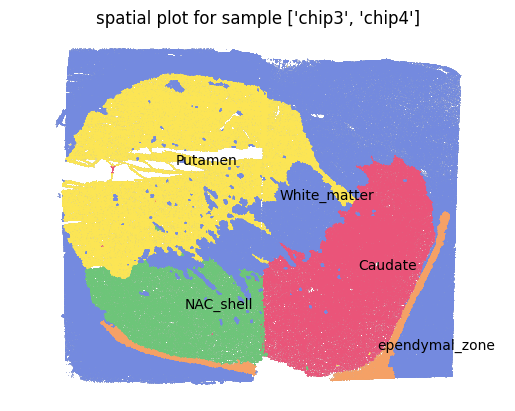

In [119]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['spatialmodule_GrayMatter_subclustered'].cat.categories)}
for chip_ID in [['chip3', 'chip4']]:
    keep = adata.obs['Chip'].isin(chip_ID)
    XN = np.array(adata[keep].obsm['spatial'])
    leiden = adata[keep].obs['spatialmodule_GrayMatter_subclustered']
    
    fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
    sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=0.2,c='gray',ax = ax)
    for ld in np.unique(leiden):
        sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=0.2,c=color_map[ld], ax = ax)
        plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
        
    plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'k'})
    plt.axis('equal')
    plt.axis('off')
    plt.show()

- NOTE: For now I will not subcluster the white matter.

In [ ]:
# save the spatial module clustering result for chip 3-4
adata.obs.to_csv(r'./../../Spatial_transcriptional_module_analysis/processed_data/chip3_4/Hierarchical_spatialModule_chip34.csv')

In [136]:
adata.obs

,dnbCount,area,orig.ident,x,y,TotalUMI,NGenes,mito,ribo,hemo,...,DNBCount_gene_foldChange,DNBCount_gene_foldChange_flag,area_flag,norm_TotalUMI,norm_TotalUMI_flag,Chip,x_aligned,y_aligned,Highlevel_spatialmodule,spatialmodule_GrayMatter_subclustered
chip3_53760105645974,83,581,sample,39162,12704,186,96,9.677419,1.075269,0.0,...,0.864583,True,True,269.235800,True,chip3,39162,12704,Gray_matter,Putamen
chip3_53695681136606,56,634,sample,39090,12689,112,63,17.857143,1.785714,0.0,...,0.888889,True,True,148.567823,True,chip3,39090,12689,Gray_matter,Putamen
chip3_54859617273842,34,506,sample,39070,12964,55,37,3.636364,0.000000,0.0,...,0.918919,True,True,91.413043,True,chip3,39070,12964,Gray_matter,Putamen
chip3_54778012895207,83,1269,sample,39081,12945,158,82,7.594937,0.000000,0.0,...,1.012195,True,True,104.710796,True,chip3,39081,12945,Gray_matter,Putamen
chip3_54400055773143,17,322,sample,39097,12855,30,16,16.666667,0.000000,0.0,...,1.062500,True,True,78.354037,True,chip3,39097,12855,Gray_matter,Putamen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chip4_76987288843012,23,373,sample,52587,61712,42,26,4.761905,9.523810,0.0,...,0.884615,True,True,92.107239,True,chip4,52587,61712,ependymal_zone,ependymal_zone
chip4_79109002687243,83,1010,sample,53081,61719,155,83,10.322581,7.741935,0.0,...,1.000000,True,True,125.534653,True,chip4,53081,61719,ependymal_zone,ependymal_zone
chip4_78812649943813,83,1174,sample,53012,61713,160,87,6.250000,8.125000,0.0,...,0.954023,True,True,111.482112,True,chip4,53012,61713,ependymal_zone,ependymal_zone
chip4_79564269220623,191,1832,sample,53187,61723,399,213,4.761905,3.258145,0.0,...,0.896714,True,True,178.156114,True,chip4,53187,61723,ependymal_zone,ependymal_zone
